In [19]:
# Import Library
#%reset
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import keras
from glob import glob
from keras.preprocessing.image import ImageDataGenerator #, img_to_array, 
from tensorflow.keras.utils import img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
import os
import pickle
import warnings
warnings.filterwarnings("ignore")
from PIL import Image

#Usare scaler

# Prepare and Review Dataset

In [20]:
# Test and Train path
with open('newResa3.pickle', 'rb') as handle:
    newResa3 = pickle.load(handle)

with open('AllPixelBand3.pickle', 'rb') as handle:
    allPixel3 = pickle.load(handle)

# Identificare qualita' e suddivisione del dataset in maniera corretta tra train e test

 Resa bassa: 58 Resa media[4500,10000]: 1472 Resa alta(>10000): 31


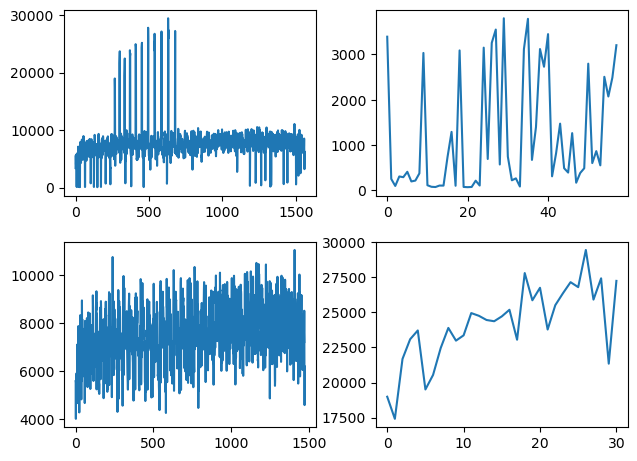

In [21]:
#taglio outliar
FilterResa3gtZero = newResa3!=0
newResa3 = newResa3[FilterResa3gtZero]
allPixel3 = allPixel3[FilterResa3gtZero,:,:]

LowValue = 1
Medium = 4000
HighValue = 12000
Resa3LowFilter = (newResa3<Medium) & (newResa3>LowValue)
Resa3MediumFilter = (newResa3>=Medium) & (newResa3<=HighValue)
Resa3HighFilter = (newResa3>HighValue)

Resa3Low = newResa3[Resa3LowFilter]
Resa3Medium = newResa3[Resa3MediumFilter]
Resa3High = newResa3[Resa3HighFilter]

Pixel3Low = allPixel3[Resa3LowFilter,:,:]
Pixel3Medium = allPixel3[Resa3MediumFilter,:,:]
Pixel3High = allPixel3[Resa3HighFilter,:,:]


print(" Resa bassa: "+str(len(Resa3Low))+ " Resa media[4500,10000]: "+ str(len(Resa3Medium))+ " Resa alta(>10000): "+ str(len(Resa3High)))

padding = 1.2
f, axarr = plt.subplots(2,2)
f.tight_layout(pad=padding)
axarr[0][0].plot(newResa3)
axarr[0][1].plot(Resa3Low)
axarr[1][0].plot(Resa3Medium)
axarr[1][1].plot(Resa3High)
plt.show()

In [22]:
def splitSet(X,Y):
    if X.shape[0] != Y.shape[0]:
        raise Exception("X and Y have different sizes")
    choice = np.random.choice(range(X.shape[0]), size=(int(X.shape[0]/2),), replace=False)
    ind = np.zeros(X.shape[0], dtype=bool)
    ind[choice] = True
    rest = ~ind
    return np.array(X[ind,:,:]),np.array(Y[ind]),np.array(X[rest,:,:]),np.array(Y[rest])

# Costruisco le immagini

[7894.7 8344.2 7455.1 6281.9 6340.3 5941.8 8960.6 7246.4 8173.1 5787. ]


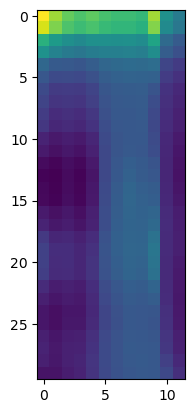

In [23]:
# Test and Train path
train_path = "dataset\\train\\"
test_path = "dataset\\test\\"

#training_setLowX, training_setLowY, test_setLowX, test_setLowY = splitSet(Pixel3Low,Resa3Low)
training_setMediumX,training_setMediumY, test_setMediumX, test_setMediumY = splitSet(Pixel3Medium,Resa3Medium)
#training_setHighX,training_setHighY, test_setHighX, test_setHighY = splitSet(Pixel3High,Resa3High)

#training_setX = np.concatenate([training_setLowX,training_setMediumX,training_setHighX],axis=0)
#training_setY = np.concatenate([training_setLowY,training_setMediumY,training_setHighY],axis=0)
training_setX = training_setMediumX
training_setY = training_setMediumY

#test_setX = np.concatenate([test_setLowX,test_setMediumX,test_setHighX],axis=0)
#test_setY = np.concatenate([test_setLowY,test_setMediumY,test_setHighY],axis=0)
test_setX = test_setMediumX
test_setY = test_setMediumY

print(training_setY[10:20])
plt.imshow(np.transpose(training_setX[0,:,:]))

#Train Set
for a in range(0,training_setX.shape[0]):
    img = Image.fromarray(training_setX[a,:,:])
    img.save(train_path+str(a)+'.tiff')

#Test Set
for a in range(0,test_setX.shape[0]):
    img = Image.fromarray(test_setX[a,:,:])
    img.save(test_path+str(a)+'.tiff')


In [24]:


# Costruiamo un dataframe Train
dFTrain = pd.DataFrame(columns=['id','target'])
dFTrain['id'] = [str(x)+".tiff" for x in list(range(0,training_setX.shape[0]))]
dFTrain['target'] = training_setY/Resa3Medium.max()
print(dFTrain.head())

# Costruiamo un dataframe Test
dFTest = pd.DataFrame(columns=['id','target'])
dFTest['id'] = [str(x)+".tiff" for x in list(range(0,test_setX.shape[0]))]
dFTest['target'] = test_setY/Resa3Medium.max()

# Prepare the dataset
#Train dataset
train_data = ImageDataGenerator().flow_from_dataframe(dataframe=dFTrain, target_size = (32,32),
                                                      directory=train_path,
                                                      x_col="id",
                                                      y_col="target",
                                                      class_mode="other")

#Test Dataset
test_data = ImageDataGenerator().flow_from_dataframe(dataframe=dFTest, target_size = (32,32),
                                                      directory=test_path,
                                                      x_col="id",
                                                      y_col="target",
                                                      class_mode="other")

       id    target
0  0.tiff  0.505640
1  1.tiff  0.535213
2  2.tiff  0.510286
3  3.tiff  0.507628
4  4.tiff  0.423138
Found 736 validated image filenames.
Found 736 validated image filenames.


In [25]:
print(dFTrain['target'].mean())
print(dFTrain['target'].median())

print(dFTest['target'].mean())
print(dFTest['target'].median())

0.6929670572280884
0.6979889869689941
0.689852774143219
0.6955350637435913


# Creazione del modello di Vgg16

In [39]:
# Import model
vgg16 = VGG16(input_shape=(32,32,3),include_top=False)

# Import model
#vgg16 = VGG16()

In [59]:
# add the layers of vgg16 in my created model.
vgg16Model = Sequential()
vgg16Model.add(vgg16)
vgg16Model.add(Flatten())

In [60]:
# Close the layers of vgg16
for layers in vgg16Model.layers:
    layers.trainable = False

In [61]:
# Last layer
vgg16Model.add(Dense(1024,activation='relu'))
vgg16Model.add(Dense(1024,activation='relu'))
vgg16Model.add(Dense(1024,activation='relu'))
vgg16Model.add(Dense(1,activation='relu'))

In [62]:
# After I added last layer in created model.
vgg16Model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 1024)              525312    
                                                                 
 dense_19 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_20 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_21 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 17,340,225
Trainable params: 2,625,537
N

In [65]:
# I create compile part.
vgg16Model.compile(loss = "mean_squared_error",
             optimizer = keras.optimizers.RMSprop(learning_rate=0.001,rho=0.9,momentum=0.0,epsilon=1e-03),
             metrics = ["mse","mae"])

TypeError: Unexpected keyword argument passed to optimizer: rho. Allowed kwargs are {'clipnorm', 'lr', 'clipvalue', 'global_clipnorm', 'decay'}.

# Training Model 

In [64]:
# Traning with model
batch_size = 32

hist_vgg16 = vgg16Model.fit(train_data, 
                                epochs = 20,
                                validation_data=test_data
                                )

Epoch 1/20
23/23 [==============================] - 5s 186ms/step - loss: 0.4911 - mse: 0.4911 - mae: 0.6930 - val_loss: 0.4873 - val_mse: 0.4873 - val_mae: 0.6899
Epoch 2/20
23/23 [==============================] - 4s 174ms/step - loss: 0.4911 - mse: 0.4911 - mae: 0.6930 - val_loss: 0.4873 - val_mse: 0.4873 - val_mae: 0.6899
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 0.4911 - mse: 0.4911 - mae: 0.6930

KeyboardInterrupt: 

In [ ]:
# Save the weights of model
#vgg16Model.save_weights("previsioneResa.h5")

# Andiamo a visualizzare i risultati della rete

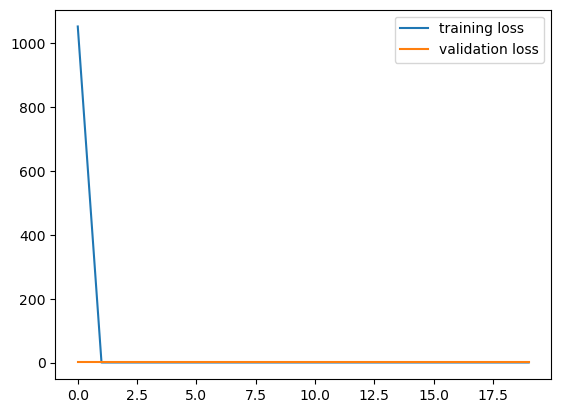

In [ ]:
# Loss and Validation Loss
plt.plot(hist_vgg16.history["loss"], label = "training loss")
plt.plot(hist_vgg16.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

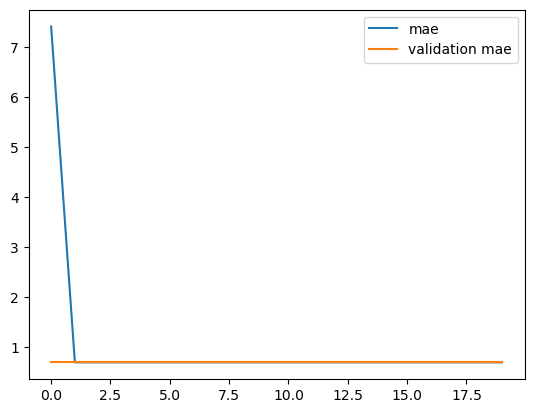

In [ ]:
# Accuracy and Validation Accuracy
plt.plot(hist_vgg16.history["mae"], label = "mae")
plt.plot(hist_vgg16.history["val_mae"], label = "validation mae")
plt.legend()
plt.show()

# Salviamo e carichiamo i risultati

In [ ]:
'''import json, codecs
with open("previsioneResa.json","w") as f:
    json.dump(hist_vgg16.history, f)'''

'import json, codecs\nwith open("previsioneResa.json","w") as f:\n    json.dump(hist_vgg16.history, f)'

In [ ]:
'''with codecs.open("./previsioneResa.json","r", encoding = "utf-8") as f:
    load_result = json.loads(f.read())'''

'with codecs.open("./previsioneResa.json","r", encoding = "utf-8") as f:\n    load_result = json.loads(f.read())'

# Vgg19

In [ ]:
# Import VGG19 model
vgg19 = VGG19(input_shape=(32,32,3),include_top=False)

In [ ]:
# Layers of vgg19
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
# add the layers of vgg16 in my created model.
vgg19Model = Sequential()
vgg19Model.add(vgg19)
vgg19Model.add(Flatten())

In [ ]:
# Close the layers of vgg16
for layers in vgg19Model.layers:
    layers.trainable = False

In [ ]:
# Last layer
vgg19Model.add(Dense(512,activation='relu'))
vgg19Model.add(Dense(1,activation='sigmoid'))

In [ ]:
# the final version of the model
vgg19Model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 512)               262656    
                                                                 
 dense_17 (Dense)            (None, 1)                 513       
                                                                 
Total params: 20,287,553
Trainable params: 263,169
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
# I create compile part.
vgg19Model.compile(loss = "mean_squared_error",
             optimizer = "rmsprop",
             metrics = ["mse","mae"])

# Addestramento

In [ ]:
# Traning with model
batch_size = 32

# Training with my created model
hisy_vgg19 = vgg19Model.fit_generator(train_data,
                               epochs = 20,
                               validation_data = test_data
                               )

Epoch 1/20
23/23 [==============================] - 5s 207ms/step - loss: 0.0324 - mse: 0.0324 - mae: 0.1324 - val_loss: 0.0122 - val_mse: 0.0122 - val_mae: 0.0893
Epoch 2/20
23/23 [==============================] - 4s 196ms/step - loss: 0.0205 - mse: 0.0205 - mae: 0.1173 - val_loss: 0.0194 - val_mse: 0.0194 - val_mae: 0.1165
Epoch 3/20
23/23 [==============================] - 5s 200ms/step - loss: 0.0191 - mse: 0.0191 - mae: 0.1113 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.1134
Epoch 4/20
23/23 [==============================] - 5s 202ms/step - loss: 0.0176 - mse: 0.0176 - mae: 0.1078 - val_loss: 0.0231 - val_mse: 0.0231 - val_mae: 0.1241
Epoch 5/20
23/23 [==============================] - ETA: 0s - loss: 0.0180 - mse: 0.0180 - mae: 0.1090

KeyboardInterrupt: 

# Visualizziamo i risultati ottenuti

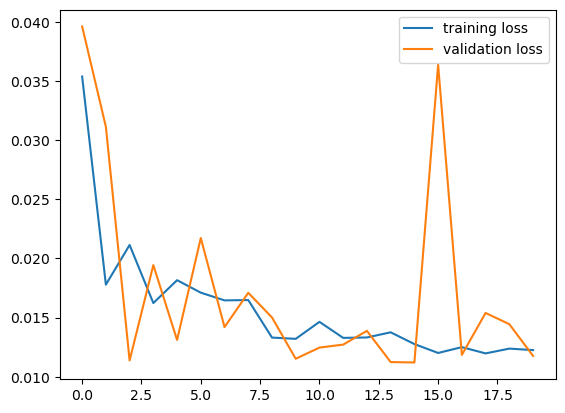

In [ ]:
# Loss And Validation Loss
plt.plot(hisy_vgg19.history["loss"], label = "training loss")
plt.plot(hisy_vgg19.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

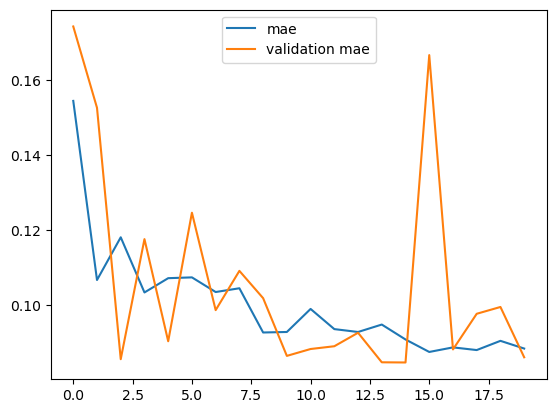

In [ ]:
# Accuracy And Validation Accuracy
plt.plot(hisy_vgg19.history["mae"], label = "mae")
plt.plot(hisy_vgg19.history["val_mae"], label = "validation mae")
plt.legend()
plt.show()

In [ ]:
val = dFTest['target'].values
print(len(val))
print(np.where(val == 1.0))

736
(array([700], dtype=int64),)


In [ ]:
predict_path = "dataset\\predict\\"

predict_data = ImageDataGenerator().flow_from_directory(directory=predict_path,target_size=(32,32))

val = dFTest['target'].values
#print(len(val))
#print(np.where(val == 1.0))
#print(dFTest['target'].where(1.0))
print(dFTest['target'][711:714])
print(dFTest['target'].mean())                                                    
prediction = vgg16Model.predict(predict_data)
print(prediction)                                         

Found 3 images belonging to 1 classes.
711    0.496737
712    0.725488
713    0.722090
Name: target, dtype: float32
0.6933218836784363
1/1 [==============================] - 0s 224ms/step
[[0.6636694]
 [0.6691647]
 [0.6743133]]
